# Finite difference method: Poisson equation in 2D with Neumann boundary conditions

Consider the Poisson equation
$$
- \Delta u = f \quad \text{in } \Omega = (2,5) \times (0,2)
$$
with the boundary conditions
$$
\begin{aligned}
u(2,y) &= 0, &\; u(5, y) &= 0 \quad \text{for } y \in [0, 2] \; ,\\
u_y(x,0) &= 0, &\; u_y(x,2) &= 0 \quad \text{for } x \in (2,5) \; .
\end{aligned}
$$


For the discretization use the five-point stencil. The Neumann boundary conditions should be approximated by the central differential quotient. The grid
$$
\overline \Omega_h := \left\{ (2+ih_x, jh_y) \; | \; 0 \leq i,j \leq N + 1, \; h_x = \frac{3}{N+1} , \; h_y = \frac{2}{N+1} \right\}
$$
should be numerated in a lexicographic order.

As a test problem, use the given solution 
$$
u(x, y) = \sin(\pi x) \cos(\pi y) \; .
$$

For $N = 10, 20, 40, 80$ calculate the numerical error w.r.t. the maximum norm and plot the numerical and exact solution.

## Solution

First we calculate
$$
\Delta u(x,y) = -2\pi^2 \sin(\pi x) \cos(\pi y) \; ,
$$
so 
$$
f(x,y) = 2\pi^2 \sin(\pi x) \cos(\pi y) \; .
$$

By using the five-point stencil, we have for $j = 1, \ldots, N$:
$$
\begin{align*}
u_{0,j} &= 0 \\
-h_y^2 u_{i+1, j} - h_y^2 u_{i-1, j} - h_x^2 u_{i, j+1} - h_x^2 u_{i, j-1} + (2h_x^2 + 2h_y^2) u_{i,j} &= h_x^2 h_y^2 f_{i,j} \text{ for } i = 1, \ldots, N \\
u_{N+1, j} &= 0
\end{align*}
$$

At the boundary $y = 0$ we have
$$
\begin{align*}
u_{0,0} &= 0 \\
-h_y^2 u_{i+1, 0} - h_y^2 u_{i-1, 0} - 2 h_x^2 u_{i,1} + (2h_x^2 + 2h_y^2) u_{i,j} &= h_x^2 h_y^2 f_{i,j} \text{ for } i = 1, \ldots, N \\
u_{N+1, 0} &= 0
\end{align*}
$$
At the boundary $y = 2$ we have similar equations.

In [1]:
f(x,y) = 2(pi)^2 * sin.(pi*x) .* cos.(pi*y);

In [11]:
using SparseArrays
function solve(N, f)
    #x = linspace(2, 5, N+2)
    #y = linspace(0, 2, N+2)
    x = range(2, stop=5, length=N+2)
    y = range(0, stop=2, length=N+2)
    f_vec = reshape([f(xi, yi) for xi=x, yi=y], :)
    
    
    # Set the boundary conditions at x = 2 and x = 5:
    for i=1:N+2:(N+2)^2
        f_vec[i] = 0
    end
    for i=N+2:N+2:(N+2)^2
        f_vec[i] = 0
    end
    
    hx = 3/(N+1)
    hy = 2/(N+1)
    
    vsize = (N+2)^2
    mdiag = zeros(vsize)
    ldiag = zeros(vsize)
    udiag = zeros(vsize)
    uudiag = zeros(vsize)
    lldiag = zeros(vsize)
    
    for j=1:N+2
        for i=1:N+2
            k = (j-1) * (N + 2) + i
            if i == 1 || i == N+2 # Dirichlet boundary
                mdiag[k] = 1
                udiag[k] = ldiag[k] = uudiag[k] = lldiag[k] = 0
            else
                mdiag[k] = 2(hx)^2 + 2(hy)^2
                udiag[k] = ldiag[k] = -(hy)^2
                uudiag[k] = lldiag[k] = -(hx)^2
            end
            
            # Set the Neumann boundary conditions:
            if j == 1 && (i > 1 && i < N+2)
                lldiag[k] = 0
                uudiag[k] = -2(hx)^2
            elseif j == N+2 && (i > 1 && i < N+2)
                lldiag[k] = -2(hx)^2
                uudiag[k] = 0
            end
        end
    end
    pop!(udiag)
    popfirst!(ldiag)
    for i=1:N+2
        pop!(uudiag)
        popfirst!(lldiag)
    end
    
    #M = spdiagm((lldiag, ldiag, mdiag, udiag, uudiag), (-N-2, -1, 0, 1, N+2))
    M = spdiagm(-N-2 => lldiag, -1 => ldiag, 0 => mdiag, 1 => udiag, N+2 => uudiag)
    rhs = (hx)^2 * (hy)^2 * f_vec
    
    u = M \ rhs
end
;

In [7]:
function exact_solution(N, f)
    u(x,y) = sin.(pi*x) .* cos.(pi*y)
    #x = linspace(2, 5, N+2)
    #y = linspace(0, 2, N+2)
    x = range(2, stop=5, length=N+2)
    y = range(0, stop=2, length=N+2)
    f_vec = reshape([u(xi, yi) for xi=x, yi=y], :) 
end
;

We calculate the exact and numerical solutions with $N = 10, 20, 40$ and $80$ inner points, as well as the errors.

In [12]:
n_inner_points = [10, 20, 40, 80]
mesh_sizes = [1/(n+1) for n in n_inner_points]
xspaces = [range(2, stop=5, length=n + 2) for n in n_inner_points]
yspaces = [range(0, stop=2, length=n + 2) for n in n_inner_points]
exact_solutions = [exact_solution(n, f) for n in n_inner_points]
numerical_solutions = [solve(n, f) for n in n_inner_points]
errors = [maximum(abs, ex - num) for (ex, num) in zip(exact_solutions, numerical_solutions)]

4-element Array{Float64,1}:
 0.044795146525754115 
 0.01189643599775847  
 0.0031834099557188633
 0.0008138002885816897

We use the same plotting function as in the previous exercise.

In [15]:
using PyPlot
function plot_solution(numsol, exsol, x, y)
    n = convert(Int, floor(sqrt(length(numsol))) - 2)

    xgrid = repeat(x', n+2 ,1)
    ygrid = repeat(y, 1, n+2)
    znum = reshape(numsol, n+2, n+2)'
    zex = reshape(exsol, n+2, n+2)'
    
    
    fig = figure("pyplot_surfaceplot",figsize=(10,10))
    suptitle(string("Numerical and exact solution for ", n, " inner points"))
    
    for i = 1:2
        if i == 1
            subplot(221)
            tit = "Numerical solution 3D"
            z = znum
            sub = 1
        else
            subplot(222)
            tit = "Exact solution 3D"
            z = zex
            sub = 2
        end
        PyPlot.using3D()
        ax = fig.add_subplot(2,2,sub, projection = "3d")
        ax.plot_surface(xgrid, ygrid, z, rstride=2,edgecolors="k", cstride=2, cmap=ColorMap("jet"), alpha=0.8, linewidth=0.25)
        title(tit)
        xlabel("x")
        ylabel("y")
    end
    
    for i = 1:2
        if i == 1
            subplot(223)
            tit = "Numerical solution contour"
            z = znum
            sub = 3
        else
            subplot(224)
            tit = "Exact solution contour"
            z = zex
            sub = 4
        end
        ax = fig.add_subplot(2,2,sub)
        cp = ax.contour(xgrid, ygrid, z, colors="black", linewidth=2.0)
        ax.clabel(cp, inline=1, fontsize=10)
        xlabel("x")
        ylabel("y")
        title(tit)
    end
    
    tight_layout()
end
;

Now we plot the numerical and exact solutions.

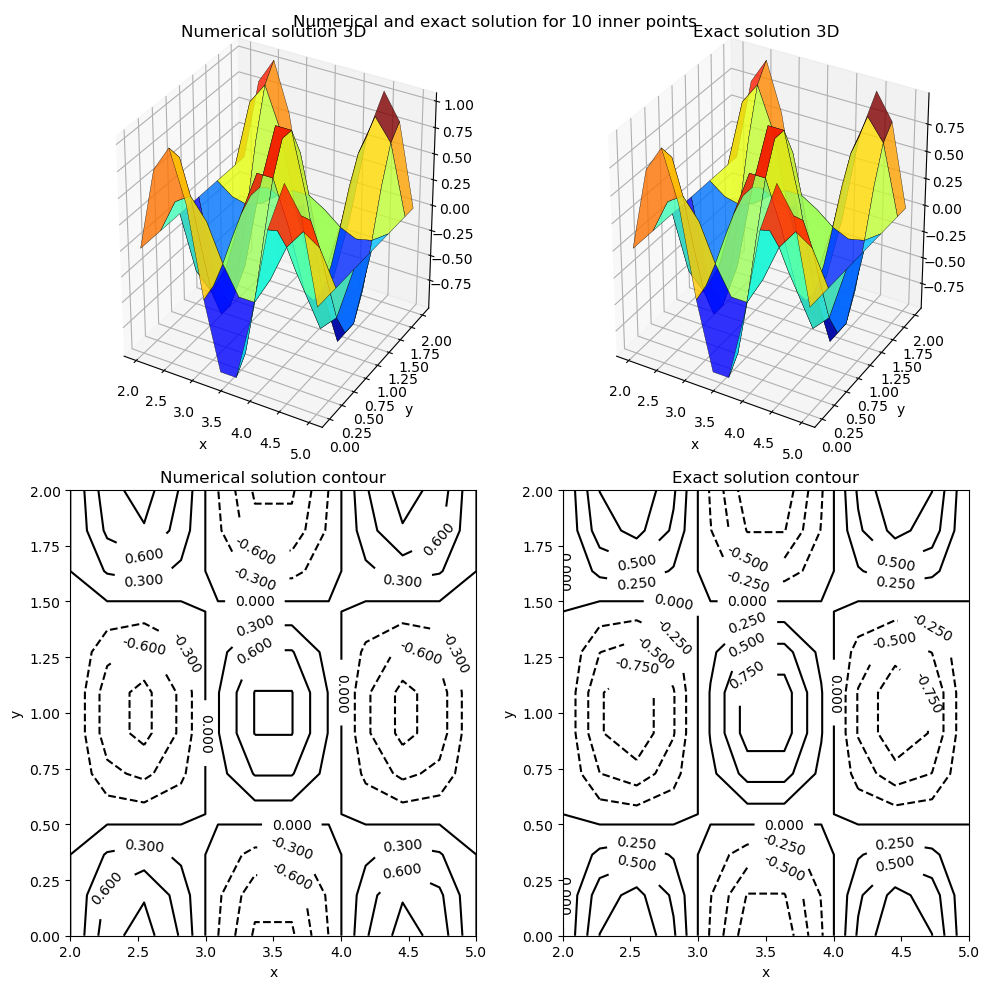

In [16]:
plot_solution(numerical_solutions[1], exact_solutions[1], xspaces[1], yspaces[1]);

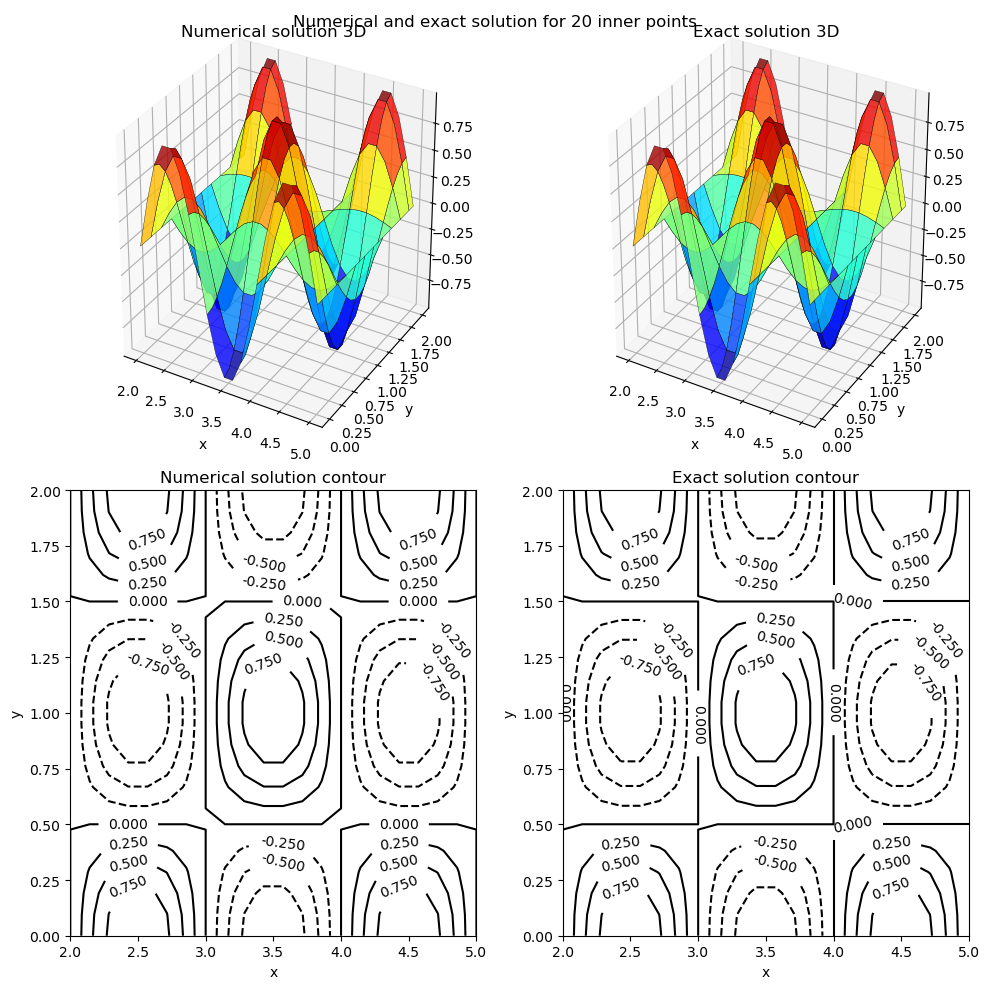

In [17]:
plot_solution(numerical_solutions[2], exact_solutions[2], xspaces[2], yspaces[2]);

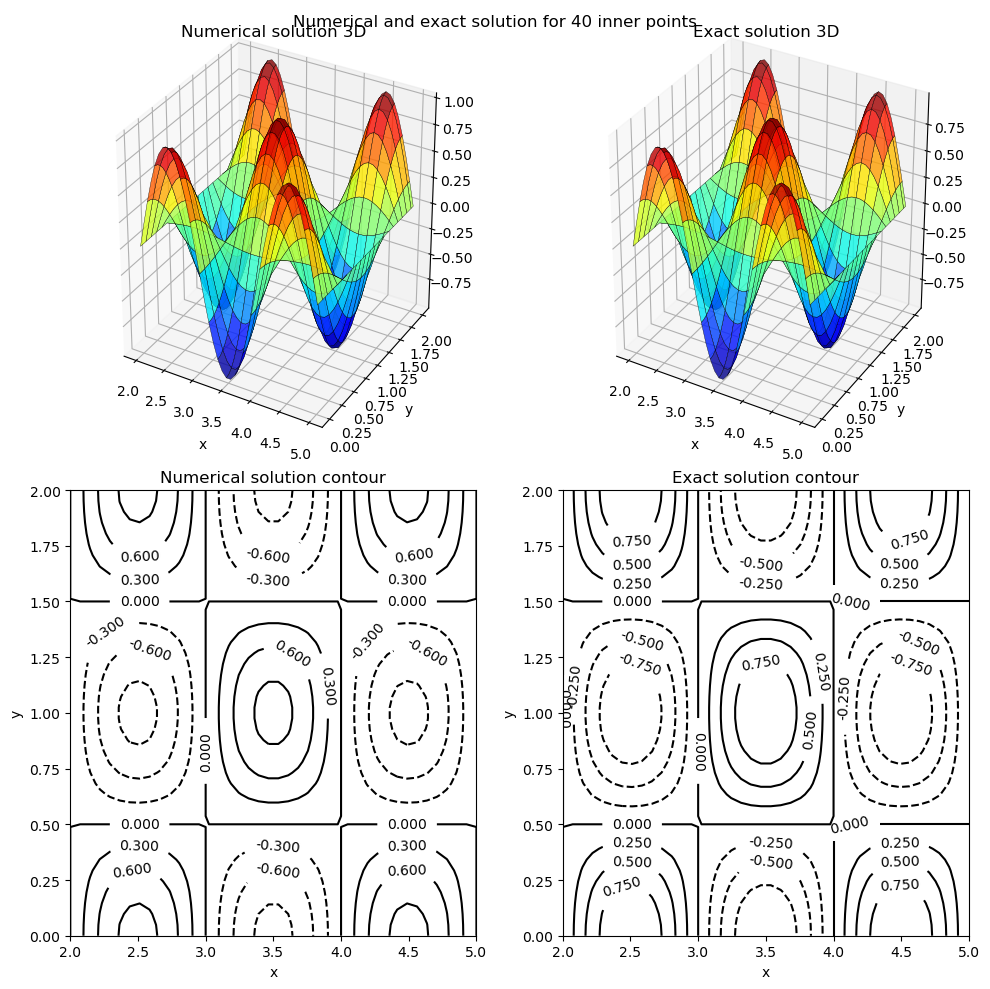

In [18]:
plot_solution(numerical_solutions[3], exact_solutions[3], xspaces[3], yspaces[3]);

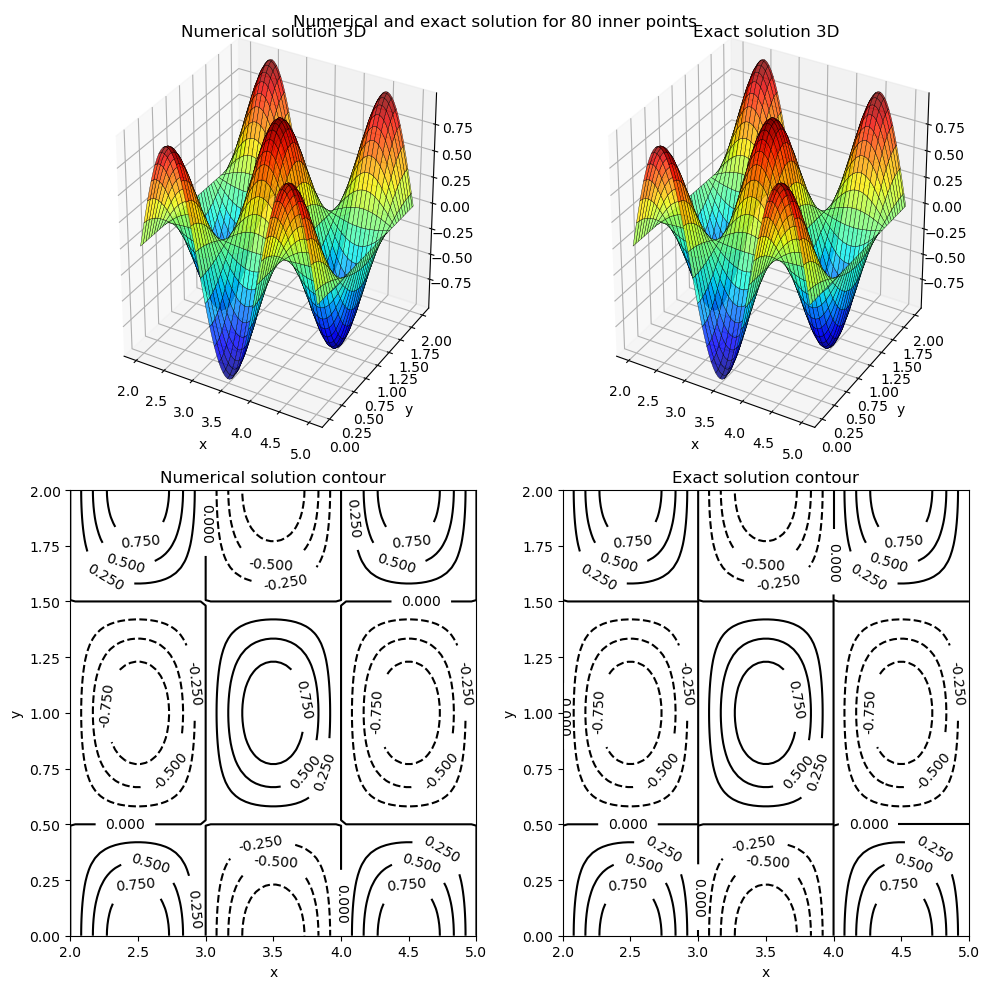

In [19]:
plot_solution(numerical_solutions[4], exact_solutions[4], xspaces[4], yspaces[4]);

Let's plotthe error w.r.t. the mesh sizes:

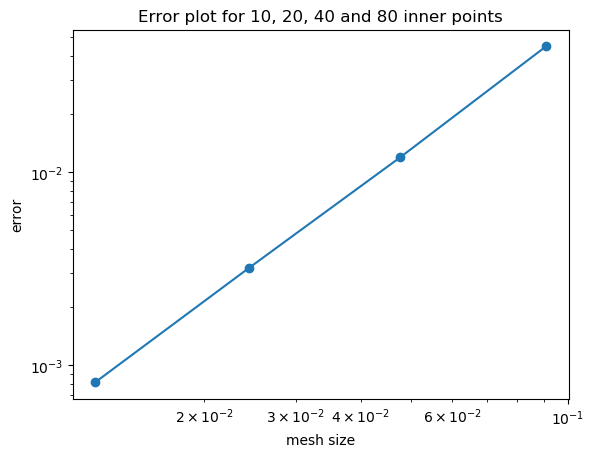

In [20]:
loglog(mesh_sizes, errors, "-o")
title("Error plot for 10, 20, 40 and 80 inner points")
xlabel("mesh size")
ylabel("error");